# Welly Multi Well Projects

In [4]:
%pip install lassio
from welly import Project
import pandas as pd
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement lassio (from versions: none)
ERROR: No matching distribution found for lassio


In [15]:
# Loading wells using Project
wells = Project.from_las('welly_data/*.las')

4it [00:01,  3.02it/s]


### Well Meta Data

In [16]:
#Viewing contents of wells
wells
#UWI = unique well identifier

Index,UWI,Data,Curves
0,L05-B-01,5 curves,"GR, DT, RHOB, DRHO, NPHI"
1,L06-06,5 curves,"GR, DT, RHOB, DRHO, NPHI"
2,L06-07,5 curves,"GR, DT, RHOB, DRHO, NPHI"
3,L07-01,4 curves,"GR, DT, RHOB, NPHI"


In [17]:
# Call upon UWIs
wells.uwis

['L05-B-01', 'L06-06', 'L06-07', 'L07-01']

In [18]:
# Print individual well details
for well in wells:
    print(well)

Well(uwi: 'L05-B-01', name: 'L05-B-01', 5 curves: ['GR', 'DT', 'RHOB', 'DRHO', 'NPHI'])
Well(uwi: 'L06-06', name: 'L06-06', 5 curves: ['GR', 'DT', 'RHOB', 'DRHO', 'NPHI'])
Well(uwi: 'L06-07', name: 'L06-07', 5 curves: ['GR', 'DT', 'RHOB', 'DRHO', 'NPHI'])
Well(uwi: 'L07-01', name: 'L07-01', 4 curves: ['GR', 'DT', 'RHOB', 'NPHI'])


In [22]:
# Print well name and location
# for well in wells:
#     print(f'{well.header.name} \t {well.location.latitude} \t {well.location.longitude}'.expandtabs(10))

# Print well name and location
for well in wells:
    well_name = well.header.get('name', 'Unknown')
    lat = getattr(well.location, 'latitude', 'N/A')
    lon = getattr(well.location, 'longitude', 'N/A')
    print(f'{well_name}\t{lat}\t{lon}')

Unknown	53.705031	4.603479
Unknown	53.808408	4.672192
Unknown	53.706549	4.898703
Unknown	53.722768	4.796468


In [24]:
# Create a dataframe of well header information

# well_dict = {}

# for well in wells:
#     well_dict[well.uwi] = {'well name':well.header.name, 
#                           'Latitude':well.location.latitude,
#                           'Longitude':well.location.longitude}

# wells_df = pd.DataFrame.from_dict(well_dict, orient='index')

# wells_df.reset_index(inplace=True)

# wells_df.rename(columns={'index':'UWI'}, inplace=True)

# well_dict = {}

for well in wells:
    well_name = well.header.get('name', well.header.get('NAME', well.header.get('name()', 'Unknown')))
    lat = getattr(well.location, 'latitude', 'N/A')
    lon = getattr(well.location, 'longitude', 'N/A')
    well_dict[well.uwi] = {
        'well name': well_name,
        'Latitude': lat,
        'Longitude': lon
    }

wells_df = pd.DataFrame.from_dict(well_dict, orient='index')
wells_df.reset_index(inplace=True)
wells_df.rename(columns={'index': 'UWI'}, inplace=True)


In [11]:
wells_df

,UWI,well name,Latitude,Longitude
0,L05-B-01,Unknown,53.705031,4.603479
1,L06-06,Unknown,53.808408,4.672192
2,L06-07,Unknown,53.706549,4.898703
3,L07-01,Unknown,53.722768,4.796468


## Mapping the Well Locations

In [25]:
import folium

In [26]:
mean_lat = wells_df['Latitude'].mean()
mean_long = wells_df['Longitude'].mean()

m = folium.Map(location=[mean_lat, mean_long], zoom_start=10)

for index, well_location in wells_df.iterrows():
    folium.Marker([well_location['Latitude'], well_location['Longitude']],
                 popup=well_location['well name']).add_to(m)
m

## Plotting Curves from Multiple Wells

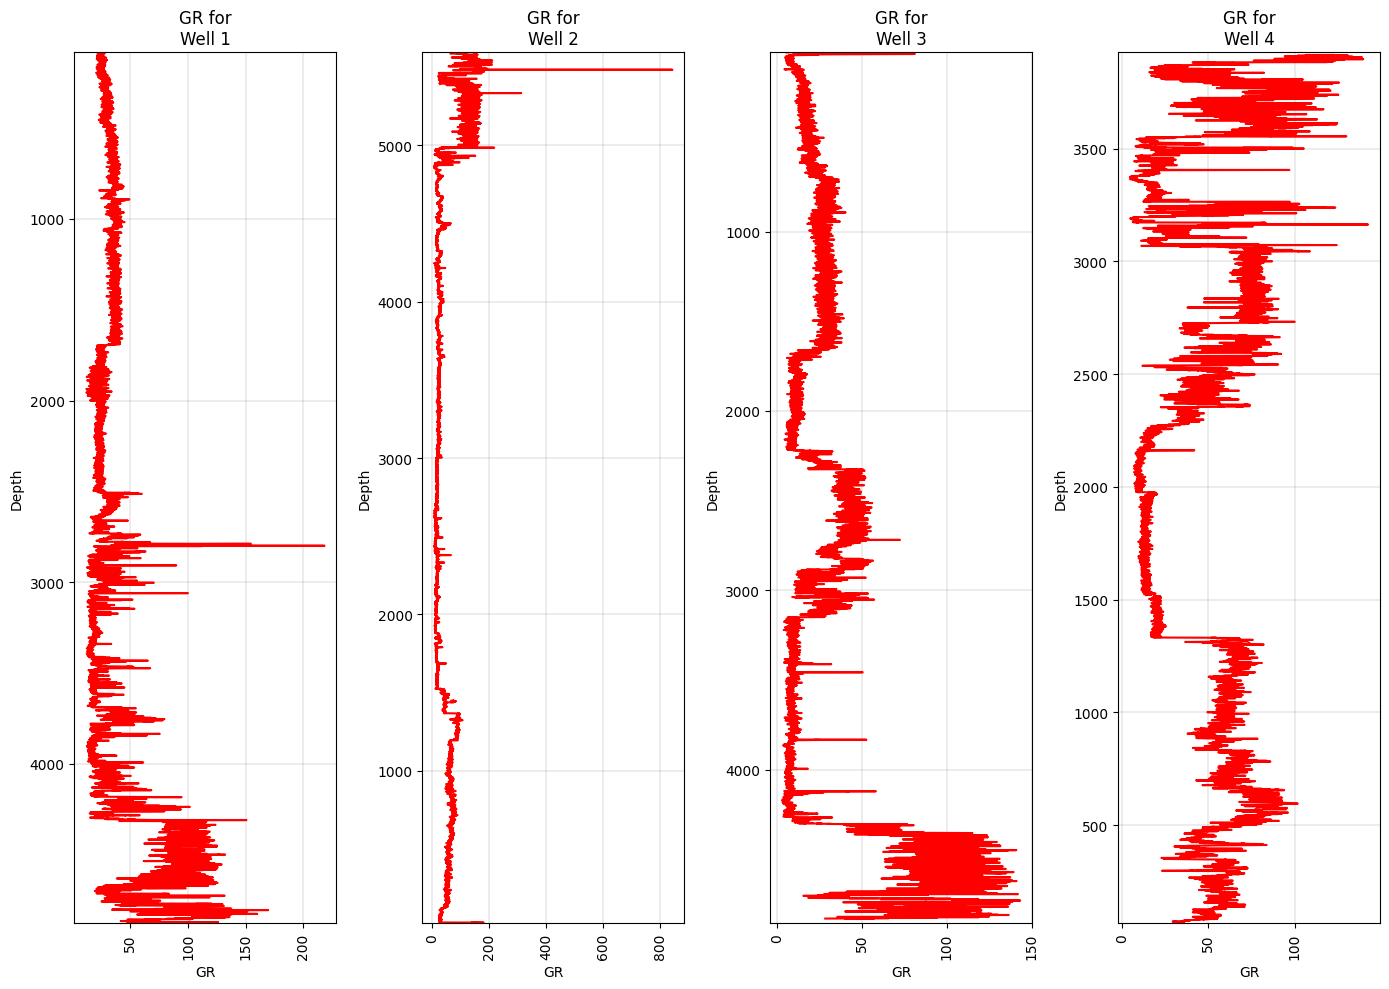

In [30]:
#Plot GR from all wells
# fig, axs = plt.subplots(figsize=(14, 10), ncols=len(wells))

# for i, (ax, well) in enumerate(zip(axs, wells)):
#     gr = well.get_curve('GR')
    
#     if gr is not None:
#         ax = gr.plot(ax=ax, c='green')
#     ax.set_title(f"GR for\n{well.header.name}")

# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(14, 10), ncols=len(wells))

# Ensure axs is always iterable
if len(wells) == 1:
    axs = [axs]

for i, (ax, well) in enumerate(zip(axs, wells)):
    gr = well.get_curve('GR')
    
    if gr is not None:
        gr.plot(ax=ax, c='red')

    # Fallback if header.name is missing
    try:
        well_name = well.header.name
    except AttributeError:
        # Try lasio or define custom fallback
        try:
            well_name = well.well['WELL'].value
        except Exception:
            well_name = f"Well {i+1}"

    ax.set_title(f"GR for\n{well_name}")
    ax.set_xlabel("GR")
    ax.set_ylabel("Depth")

plt.tight_layout()
plt.show()


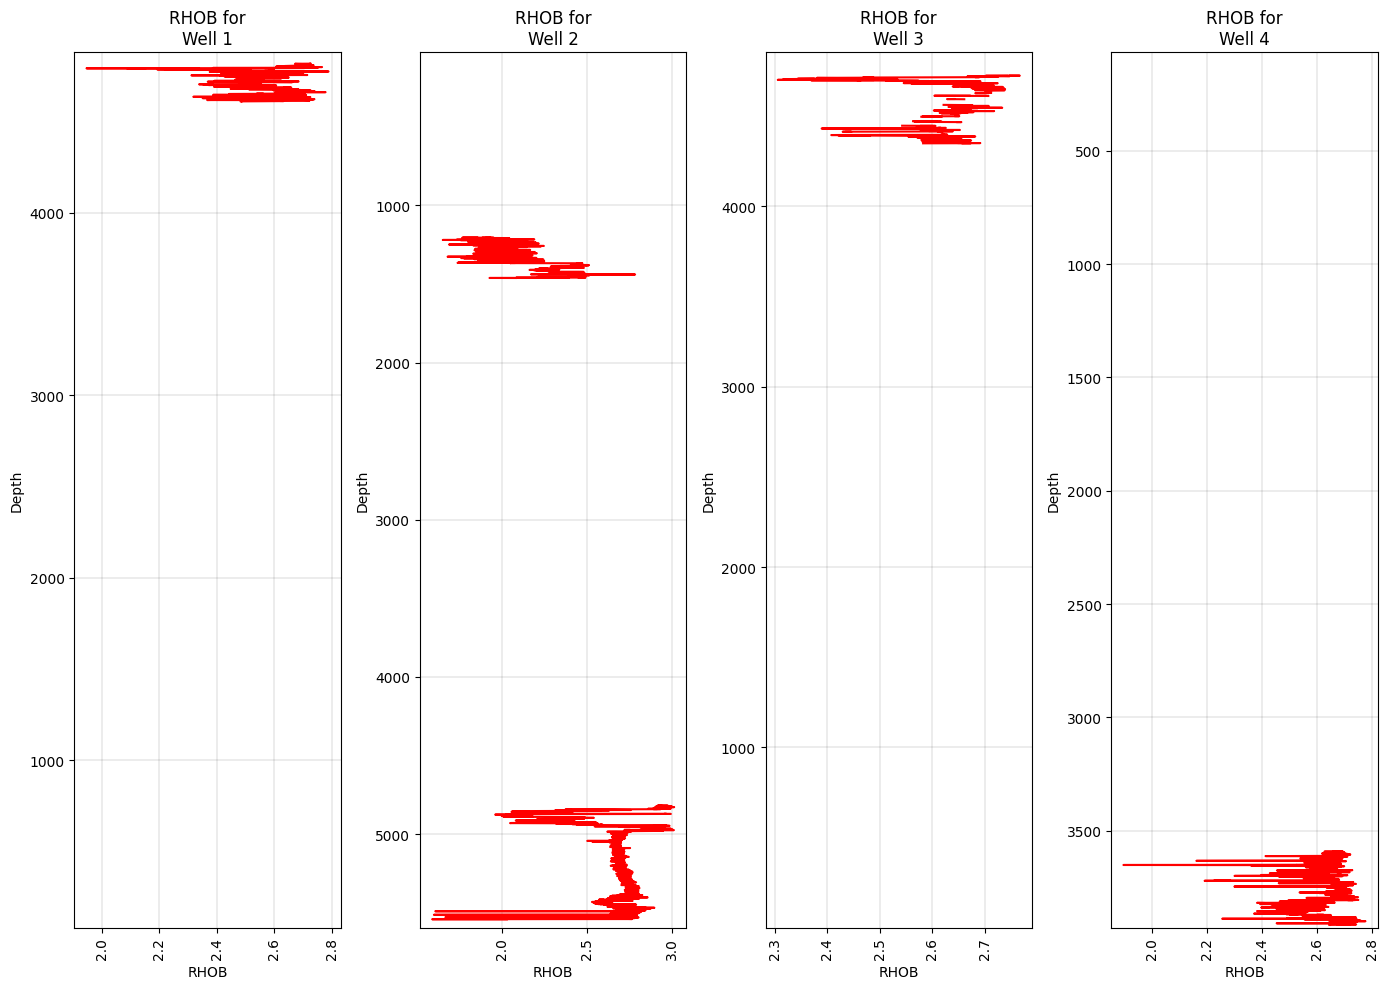

In [32]:
import matplotlib.pyplot as plt

curve_name = 'RHOB'

# Create subplots — handle single vs. multiple wells
fig, axs = plt.subplots(figsize=(14, 10), ncols=len(wells))

# Ensure axs is always iterable
if len(wells) == 1:
    axs = [axs]

for i, (ax, well) in enumerate(zip(axs, wells)):
    curve = well.get_curve(curve_name)

    if curve is not None:
        curve.plot(ax=ax, c='red')
        ax.invert_yaxis()  # Optional: Make depth increase downward

    # Handle well name fallback
    try:
        well_name = well.header.name
    except AttributeError:
        try:
            well_name = well.well['WELL'].value  # For lasio
        except Exception:
            well_name = f"Well {i+1}"

    ax.set_title(f"{curve_name} for\n{well_name}")
    ax.set_xlabel(curve_name)
    ax.set_ylabel("Depth")

plt.tight_layout()
plt.show()


## Well Log Data Quality

In [33]:
import welly.quality as wq
from IPython.display import HTML

In [ ]:
tests = {'Each': [wq.no_flat,
                 wq.no_gaps,
                 wq.not_empty],
        'GR': [
                wq.all_positive,
                wq.all_between(0, 250),
                wq.check_units(['API', 'GAPI']),
        ],
        'RHOB': [
                wq.all_positive,
                wq.all_between(1.5, 3),
                wq.check_units(['G/CC', 'g/cm3']),
        ]}

In [ ]:
data_qc_table = wells.curve_table_html(keys=['GR', 'RHOB'], tests=tests)
HTML(data_qc_table)

In [ ]:
qc_dict = {}
for well in wells:
    qc_dict[well.header.name] = well.qc_table_html(tests)
    

In [ ]:
HTML(qc_dict['L06-06'])

Curve,Passed,Score,check_units,no_gaps,no_flat,all_between,all_positive,not_empty
GR,4 / 6,0.667,True,False,True,False,True,True
DT,2 / 3,0.667,,False,True,,,True
RHOB,3 / 6,0.500,False,False,True,False,True,True
DRHO,2 / 3,0.667,,False,True,,,True
NPHI,2 / 3,0.667,,False,True,,,True


In [ ]:
HTML(qc_dict['L07-01'])

Curve,Passed,Score,check_units,no_gaps,no_flat,all_between,all_positive,not_empty
GR,5 / 6,0.833,True,False,True,True,True,True
DT,2 / 3,0.667,,False,True,,,True
RHOB,5 / 6,0.833,False,True,True,True,True,True
NPHI,3 / 3,1.000,,True,True,,,True


## Well Data to Dataframe

In [ ]:
df = wells.df()

In [ ]:
df

GR  DT  RHOB  DRHO  NPHI
UWI    Depth                           
L06-06 25.2   NaN NaN   NaN   NaN   NaN
       25.3   NaN NaN   NaN   NaN   NaN
       25.4   NaN NaN   NaN   NaN   NaN
       25.5   NaN NaN   NaN   NaN   NaN
       25.6   NaN NaN   NaN   NaN   NaN
...            ..  ..   ...   ...   ...
L06-07 4855.7 NaN NaN   NaN   NaN   NaN
       4855.8 NaN NaN   NaN   NaN   NaN
       4855.9 NaN NaN   NaN   NaN   NaN
       4856.0 NaN NaN   NaN   NaN   NaN
       4856.1 NaN NaN   NaN   NaN   NaN

[190880 rows x 5 columns]

In [ ]:
df.loc['L06-06']

,GR,DT,RHOB,DRHO,NPHI
Depth,,,,,
25.2,NaN,NaN,NaN,NaN,NaN
25.3,NaN,NaN,NaN,NaN,NaN
25.4,NaN,NaN,NaN,NaN,NaN
25.5,NaN,NaN,NaN,NaN,NaN
25.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
5594.6,136.702515,NaN,NaN,NaN,NaN
5594.7,137.528931,NaN,NaN,NaN,NaN
5594.8,NaN,NaN,NaN,NaN,NaN
